## RNN 으로 주가예측하기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

## 주가수집

In [2]:
# 삼성전자 주가 수집
df = fdr.DataReader("005930", "2020")
df.shape

(645, 6)

In [3]:
df.head(2)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435


In [4]:
df.tail(2)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-08-08,61400,61400,60600,60800,11313150,-0.011382
2022-08-09,60600,60700,59800,59900,4566071,-0.014803


## 문제, 답안 나누기

In [5]:
df_ohlcv = df.iloc[:, :-1]

dfx = df_ohlcv.drop(columns="Close")
dfy = df_ohlcv["Close"]
dfx.shape

(645, 4)

## 정규화 

In [6]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
# 복원을 위해 x, y 따로 스케일링하기
# 스케일링 후 list 형태로 변환하기
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()
x = mmsx.fit_transform(dfx).tolist()
y = mmsy.fit_transform(dfy.to_frame()).tolist()

In [7]:
len(x), len(y)

(645, 645)

## x, y 값 window_size 적용하기


<center>
<img src = "https://i.stack.imgur.com/padg4.gif">
</center>
* 이미지출처: https://stackoverflow.com/questions/31947183/how-to-implement-walk-forward-testing-in-sklearn


In [8]:
window_size = 10
len(y) - window_size

635

In [9]:
window_size = 10 

x_data = []
y_data = []
for i in range(len(y) - window_size):
    # print(i, end=",")
    _x = x[i : i+window_size]
    _y = y[i+window_size]
    x_data.append(_x)
    y_data.append(_y)

In [10]:
len(x_data), len(y_data)

(635, 635)

In [11]:
pd.DataFrame(x_data).shape

(635, 10)

In [12]:
pd.DataFrame(x_data).iloc[0, 0]

[0.2704402515723271,
 0.23380281690140836,
 0.26906779661016944,
 0.09828722395094776]

## train, test 나누기

In [13]:
# 8:2 로 나누기
split_size = int(len(x_data) * 0.8)
split_size

508

In [14]:
X_train = np.array(x_data[:split_size])
y_train = np.array(y_data[:split_size])
X_test = np.array(x_data[split_size:])
y_test = np.array(y_data[split_size:])

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((508, 10, 4), (508, 1), (127, 10, 4), (127, 1))

## 모델 생성

In [16]:
data_size = dfx.shape[1]
data_size

4

In [17]:
# 모델 생성
model = Sequential()
model.add(LSTM(units=10, activation="relu", return_sequences=True, 
               input_shape=(window_size, data_size)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=10, activation="relu")))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 10)            600       
                                                                 
 dropout (Dropout)           (None, 10, 10)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 20)               1680      
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 2,301
Trainable params: 2,301
Non-trainable params: 0
______________________________________________________

2022-08-09 09:28:39.858668: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## compile

In [18]:
model.compile(optimizer="adam", 
              loss="mse", 
              metrics=["mse", "mae"])

## 학습과 예측

In [19]:
X_train.shape, y_train.shape

((508, 10, 4), (508, 1))

In [20]:
history = model.fit(X_train, y_train, epochs=100, batch_size=30, verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [21]:
df_hist = pd.DataFrame(history.history)

<AxesSubplot:>

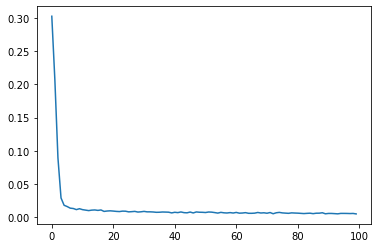

In [22]:
df_hist["loss"].plot()

In [23]:
y_pred = model.predict(X_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [24]:
# rmse
np.sqrt(np.square(y_test - y_pred).mean())

0.029491482143467397

## 예측 결과 시각화

In [34]:
y_test.shape, y_pred.shape

((127, 1), (127, 1))

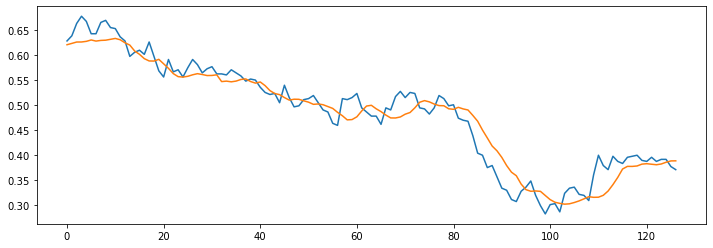

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.flatten())
plt.plot(y_pred.flatten())